In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns


In [1]:
#matplotlib inline
plt.style.use('ggplot')

NameError: name 'plt' is not defined

In [ ]:
#function to read data file
def read_data(file_path):
    columns_names = ['user_id','activity','timestamp','x-axis','y_axis','z_axis']
    data = pd.read_csv(file_path,header = None, names = columns_names)
    return data

#normalize raw data 
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

def plot_axis(ax, x, y ,title):
    ax.plot(x,y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (20, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y_axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z_axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


Text(0.5, 1.0, "Nombres d'occurences d'activites")

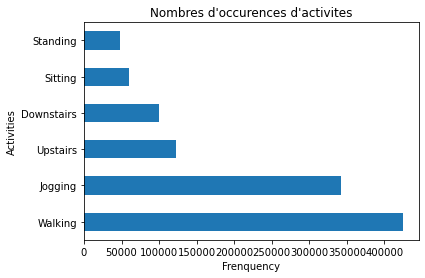

In [4]:
dataset = read_data('/Stage 4A/data/data1.txt')
dataset.dropna(axis=0, how='any', inplace= True) # remove any null row

plt.figure()

acti = dataset['activity'].value_counts().plot(kind = 'barh')



plt.ylabel('Activities')
plt.xlabel('Frenquency')
plt.title("Nombres d'occurences d'activites")


In [5]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y_axis'] = feature_normalize(dataset['y_axis'])
dataset['z_axis'] = feature_normalize(dataset['z_axis'])



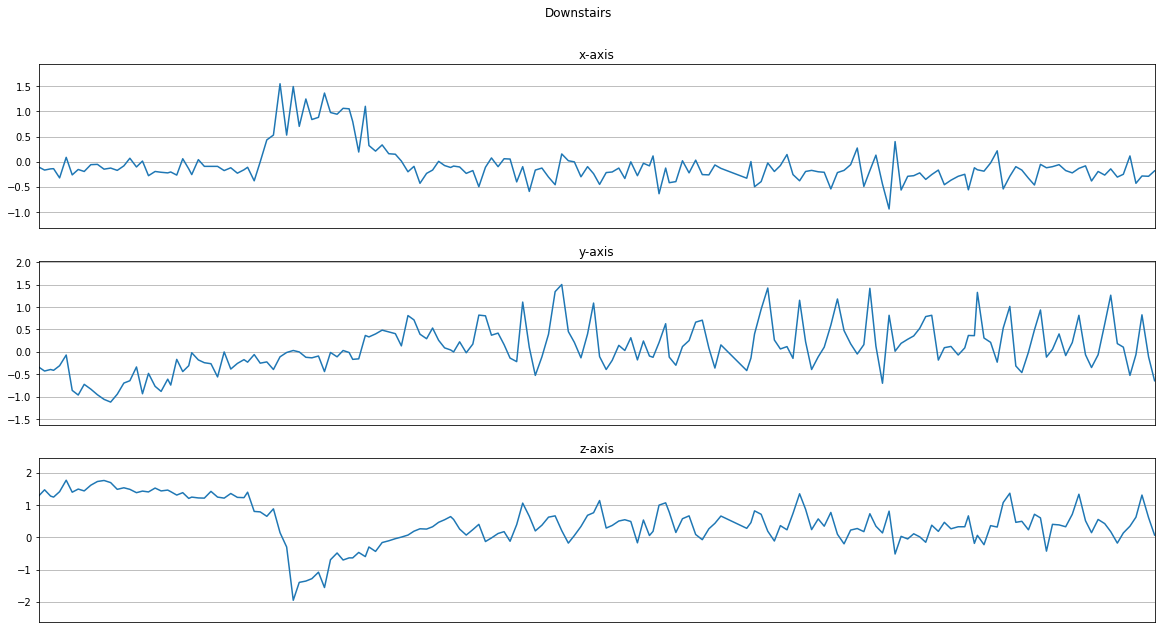

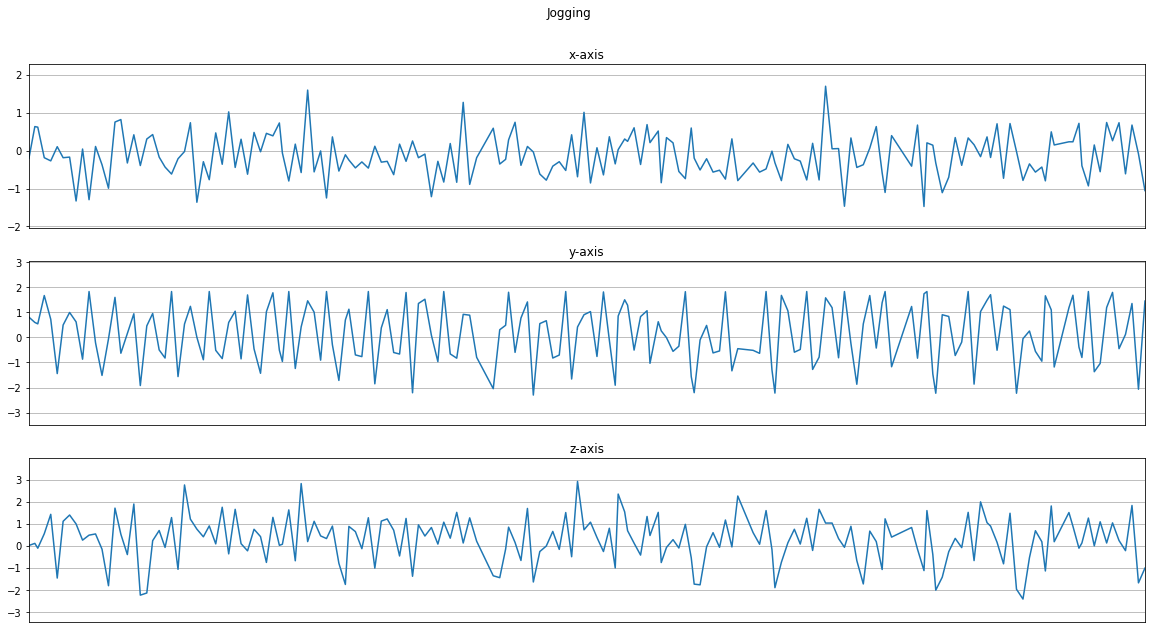

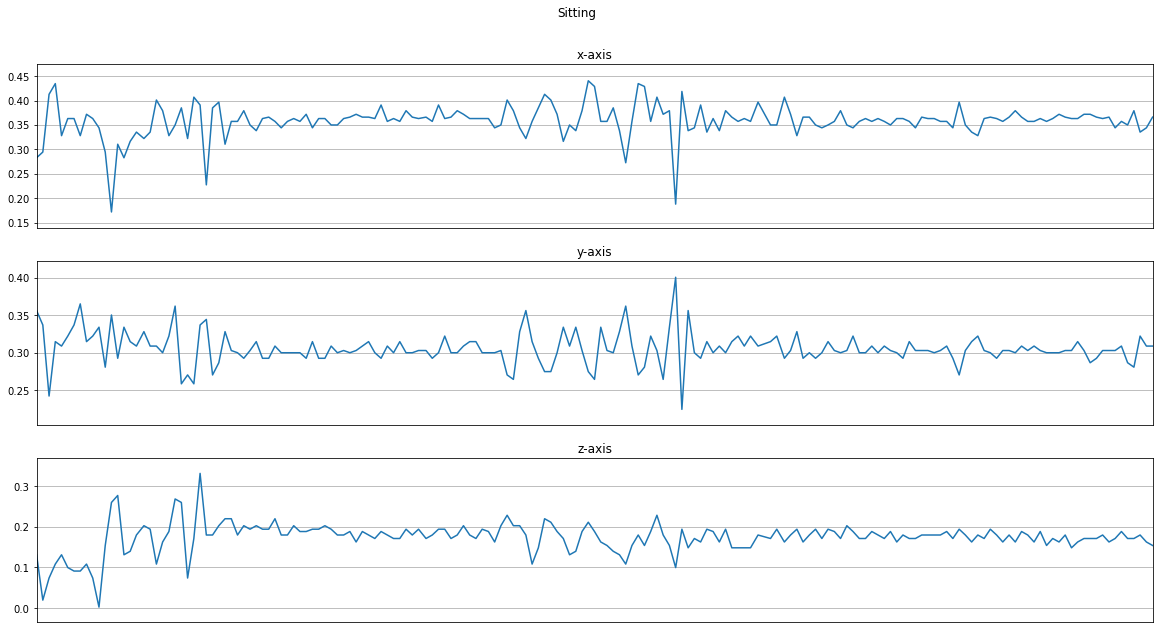

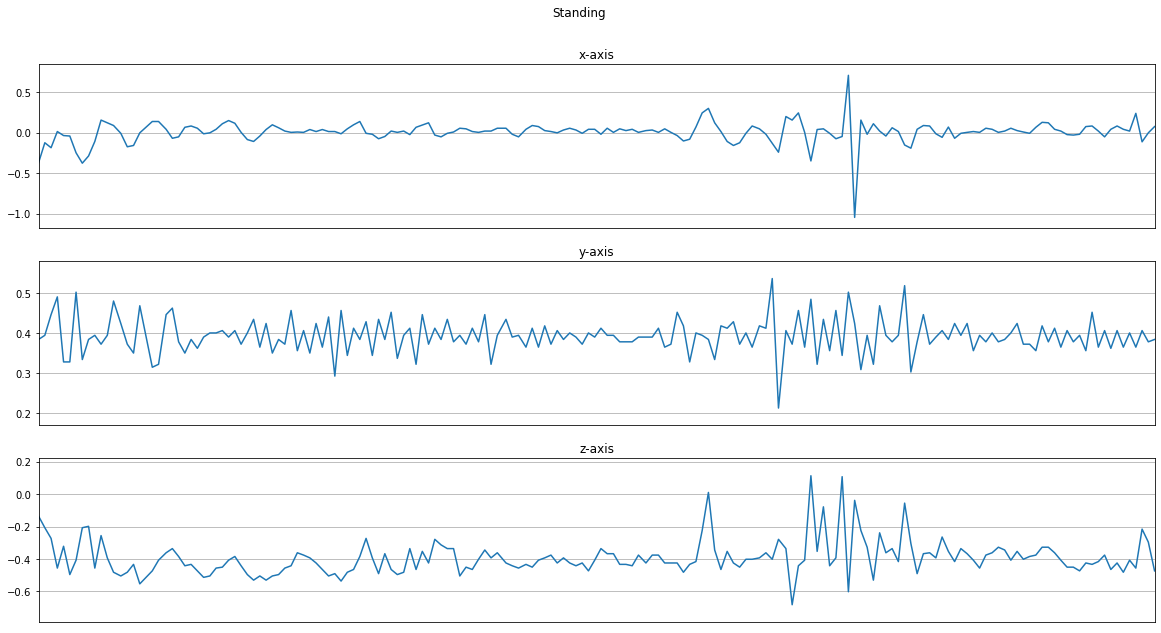

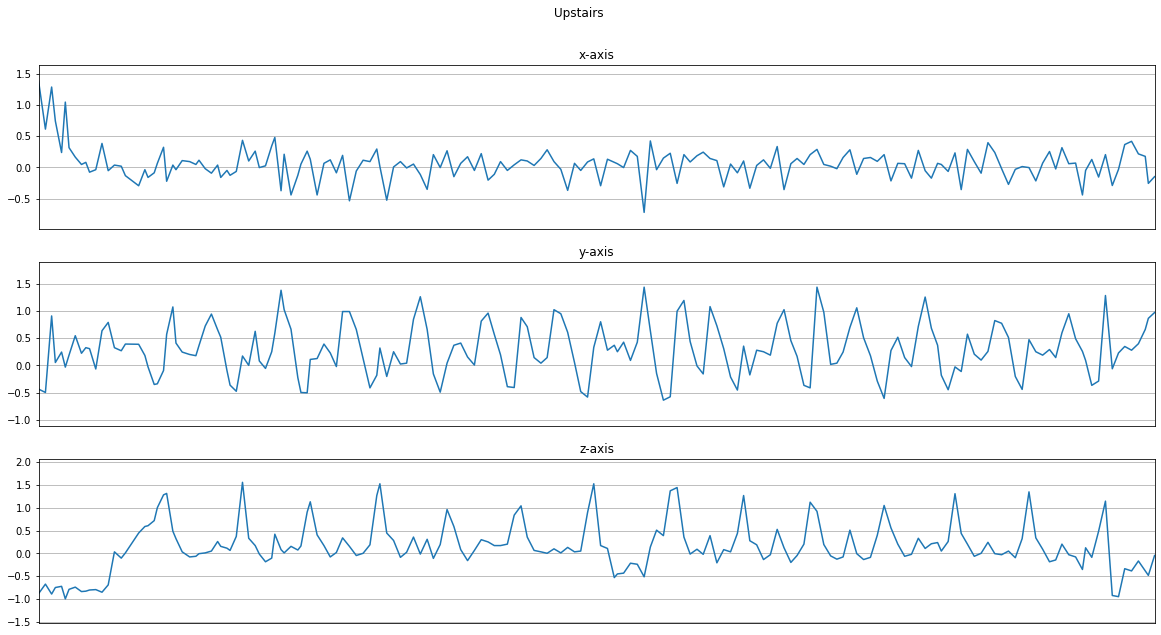

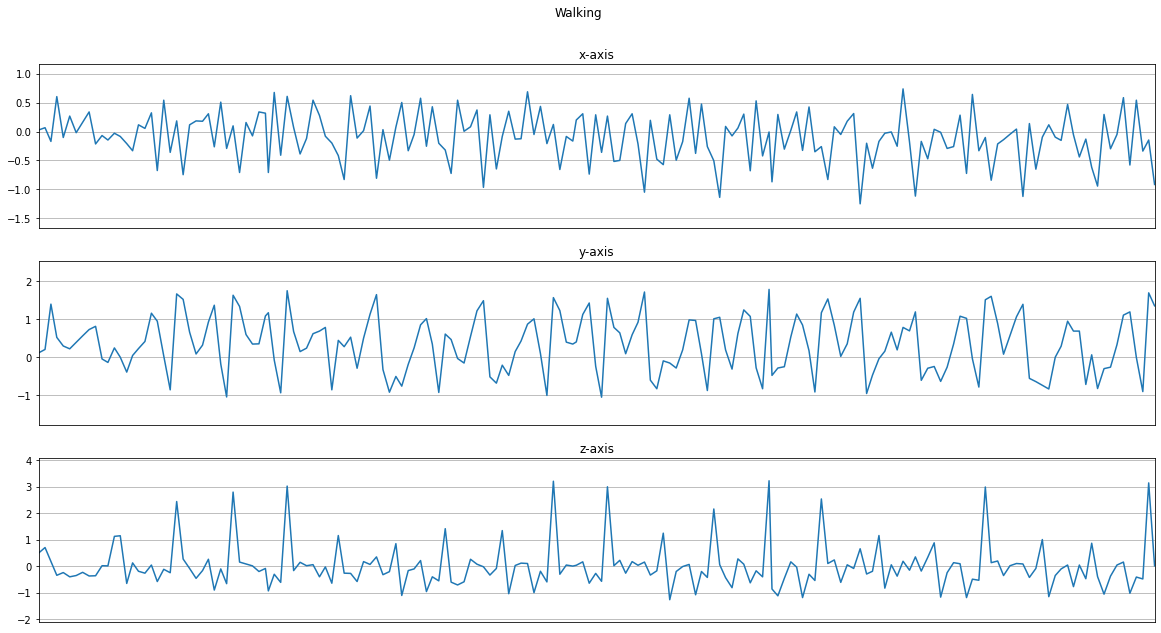

In [6]:
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:180]
    plot_activity(activity,subset)

In [8]:
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)
#function to split segment signal
def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data["timestamp"], window_size):
        x = data["x-axis"][start:end]
        y = data["y_axis"][start:end]
        z = data["z_axis"][start:end]
        if(len(dataset["timestamp"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels
    

In [9]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)  # 1 x 90 , 3 chanel input is x y z 

In [10]:
#split data into test and train data 30/70

train_test_split = np.random.rand(len(reshaped_segments)) < 0.70
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

In [11]:
#prepare CNN

input_height = 1
input_width = 90
num_labels = 6
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 64

total_batchs = train_x.shape[0] // batch_size

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))

def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1],
                          strides=[1, 1, stride_size, 1], padding='VALID')


In [12]:
tf.compat.v1.disable_eager_execution()
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [13]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for batch in range(total_batchs):
            offset = (batch * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",np.mean(cost_history)," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

    


Epoch:  0  Training Loss:  7.2776719292152015  Training Accuracy:  0.788046
Epoch:  1  Training Loss:  12.281578337868869  Training Accuracy:  0.8269052
Epoch:  2  Training Loss:  16.605798717193373  Training Accuracy:  0.8453183
Epoch:  3  Training Loss:  20.55906134287196  Training Accuracy:  0.8556575
Epoch:  4  Training Loss:  24.25254371085728  Training Accuracy:  0.86407995
Epoch:  5  Training Loss:  27.740517749656618  Training Accuracy:  0.8717472
Epoch:  6  Training Loss:  31.054807213679553  Training Accuracy:  0.8773815
Epoch:  7  Training Loss:  34.21729042548228  Training Accuracy:  0.882493
Epoch:  8  Training Loss:  37.24319420385889  Training Accuracy:  0.8877207
Epoch:  9  Training Loss:  40.144259833501174  Training Accuracy:  0.8921933
Epoch:  10  Training Loss:  42.93059481260453  Training Accuracy:  0.89684016
Epoch:  11  Training Loss:  45.611437142072624  Training Accuracy:  0.90084803
Epoch:  12  Training Loss:  48.194501270351594  Training Accuracy:  0.90276486